In [1]:
import cv2
import numpy as np

# Grayscales an image
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def normalize(value):
    return value / 255 * 2 - 1

def preprocess_image(image):
    img = grayscale(image)
    img = normalize(img)
    return np.array(img).reshape(32,32,1)

def preprocess_batch(images):
    imgs = np.zeros(shape=images.shape)
    processed_image_depth = preprocess_image(images[0]).shape[2]
    imgs = imgs[:,:,:,0:processed_image_depth]
    for i in tqdm(range(images.shape[0])):
        imgs[i] = preprocess_image(images[i])        
    return imgs

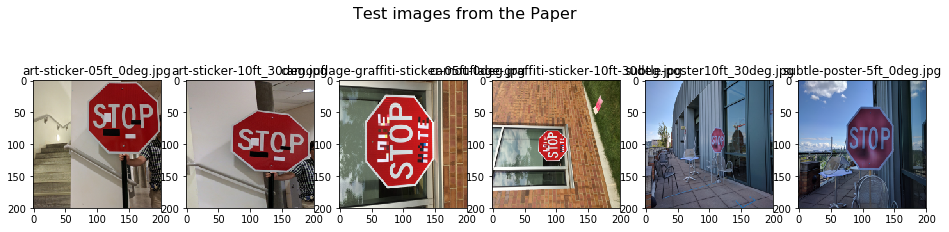

In [12]:
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg

img_folder = '../experimental_attack_images/'
test_images = []
test_responses = [13, 13, 13, 13, 13, 13]
fig = plt.figure(figsize=(16,4))
fig.suptitle('Test images from the Paper', fontsize=16)

cnt = 0
for img_name in os.listdir(img_folder):
    if not img_name.endswith('.ipynb_checkpoints'):
        image = mpimg.imread(img_folder+img_name)
        image_to_show = cv2.resize(image, (200, 200), interpolation = cv2.INTER_AREA)
        image = cv2.resize(image, (32, 32), interpolation = cv2.INTER_AREA)
        cnt = cnt+1
        sub=plt.subplot(1,6,cnt)
        sub.set_title(img_name)
        plt.imshow(image_to_show)
        image = preprocess_image(image) 
        test_images.append(image)
    
    
test_images = np.array(test_images)

In [3]:
print(test_images.shape)

(6, 32, 32, 1)


In [13]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 10
BATCH_SIZE = 128
image_depth = 1
n_classes = 17

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, image_depth, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
        
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


x = tf.placeholder(tf.float32, (None, 32, 32, image_depth))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.003

logits = LeNet(x)

In [14]:
signnames = []
file = open('./data/categories.txt', 'r') 
for line in file: 
    line = line.strip('\n')
    signnames.append(line) 

In [15]:
pred_val = tf.argmax(logits, 1)
pred_softmax = tf.nn.softmax(logits)
pred_topFive = tf.nn.top_k(pred_softmax, k=5)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lisa-cnn/model.meta')
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir='./lisa-cnn/'))
    pred_val_out, pred_topFive_out = sess.run([pred_val, pred_topFive], feed_dict={x: test_images, y: test_responses})
    
print("Predicted Labels")
print(pred_val_out)
print()
  
cnt = 0
correct_cnt = 0
for i in pred_val_out:
    correctness = "Correct"
    if test_responses[cnt] == i:
        correctness = "Correct"
        correct_cnt = correct_cnt + 1
    else:
        correctness = "Not correct!"
      
    print("{} - {} -> {}".format(i, signnames[i], correctness))
    cnt = cnt + 1

INFO:tensorflow:Restoring parameters from ./lisa-cnn/model
Predicted Labels
[ 0  1  1 16  1 16]

0 - addedLane -> Not correct!
1 - keepRight -> Not correct!
1 - keepRight -> Not correct!
16 - yield -> Not correct!
1 - keepRight -> Not correct!
16 - yield -> Not correct!


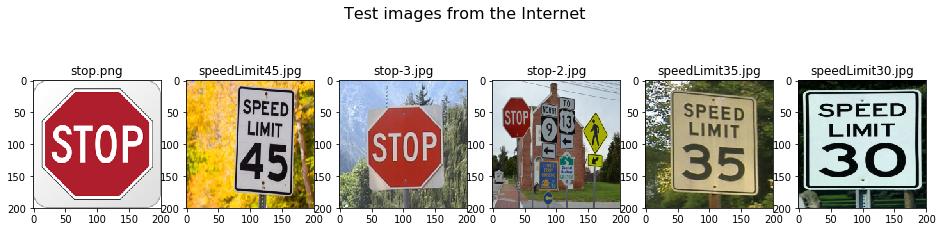

In [16]:
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg

img_folder = '../traffic-signs/'
test_images = []
test_responses = [13, 11, 13, 13, 10, 9]
fig = plt.figure(figsize=(16,4))
fig.suptitle('Test images from the Internet', fontsize=16)


cnt = 0
for img_name in os.listdir(img_folder):
    if not img_name.endswith('.ipynb_checkpoints'):
        image = mpimg.imread(img_folder+img_name)
        image_to_show = cv2.resize(image, (200, 200), interpolation = cv2.INTER_AREA)
        image = cv2.resize(image, (32, 32), interpolation = cv2.INTER_AREA)
        cnt = cnt+1
        sub=plt.subplot(1,6,cnt)
        sub.set_title(img_name)
        plt.imshow(image_to_show)
        image = preprocess_image(image) 
        test_images.append(image)
    
    
test_images = np.array(test_images)

In [17]:
pred_val = tf.argmax(logits, 1)
pred_softmax = tf.nn.softmax(logits)
pred_topFive = tf.nn.top_k(pred_softmax, k=5)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lisa-cnn/model.meta')
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir='./lisa-cnn/'))
    pred_val_out, pred_topFive_out = sess.run([pred_val, pred_topFive], feed_dict={x: test_images, y: test_responses})
    
print("Predicted top five")
print(pred_topFive_out)
print()

cnt = 0
correct_cnt = 0
for i in pred_val_out:
    correctness = "Correct"
    if test_responses[cnt] == i:
        correctness = "Correct"
        correct_cnt = correct_cnt + 1
    else:
        correctness = "Not correct!"
      
    print("{} - {} -> {}".format(i, signnames[i], correctness))
    cnt = cnt + 1

INFO:tensorflow:Restoring parameters from ./lisa-cnn/model
Predicted top five
TopKV2(values=array([[0.06433493, 0.06355527, 0.06196938, 0.0617572 , 0.06129042],
       [0.06495019, 0.06175182, 0.06156608, 0.06042399, 0.05985913],
       [0.06258937, 0.06258868, 0.06082227, 0.06009904, 0.05998876],
       [0.06188628, 0.06142289, 0.0614021 , 0.06075732, 0.06055626],
       [0.06146729, 0.06049231, 0.06021111, 0.06004499, 0.05951363],
       [0.07011239, 0.06644391, 0.0626173 , 0.06202212, 0.06156199]],
      dtype=float32), indices=array([[ 3, 15,  9,  2, 10],
       [11, 16,  0, 15, 14],
       [15, 11,  0,  2,  9],
       [11,  3, 15,  2,  0],
       [11, 14, 15, 16,  0],
       [11,  0,  2, 16,  3]], dtype=int32))

3 - merge -> Not correct!
11 - speedLimit45 -> Correct
15 - turnRight -> Not correct!
11 - speedLimit45 -> Not correct!
11 - speedLimit45 -> Not correct!
11 - speedLimit45 -> Not correct!


In [28]:
# Define some parameters for the attacks:
max_epsilon = 8  # Max epsilon on the original range (0 to 255)
max_iter = 30 # Maximun number of iterations
eps = 2.0 * max_epsilon / 255.0 # Max epsilon on the range of the processed images (-1 to 1)

In [29]:
import tensorflow as tf
import numpy as np


class RP2_attack:
    """ Creates adversarial samples using a projected gradient descent attack
    """
    def __init__(self, model, 
                 batch_shape, 
                 max_epsilon, 
                 max_iter, 
                 targeted, 
                 img_bounds=[-1, 1],
                 use_noise=True,
                 initial_lr=0.5, 
                 lr_decay=0.98,
                 n_classes=17,
                 rng = np.random.RandomState()):
        """ 
             model: Callable (function) that accepts an input tensor 
                    and return the model logits (unormalized log probs)
             batch_shape: Input shapes (tuple). 
                    Usually: [batch_size, height, width, channels]
             max_epsilon: Maximum L_inf norm for the adversarial example
             max_iter: Maximum number of gradient descent iterations
             targeted: Boolean: true for targeted attacks, false for non-targeted attacks
             img_bounds: Tuple [min, max]: bounds of the image. Example: [0, 255] for
                    a non-normalized image, [-1, 1] for inception models.
             initial_lr: Initial Learning rate for the optimization
             lr_decay: Learning rate decay (multiplied in the lr in each iteration)
             rng: Random number generator 
             
        """
        self.x_input = tf.placeholder(tf.float32, shape=batch_shape)
        self.y_input = tf.placeholder(tf.int32, shape=(batch_shape[0]))
        
        # Loss function: the mean of the logits of the correct class
        y_onehot = tf.one_hot(self.y_input, n_classes)
        logits = model(self.x_input)
        logits_correct_class = tf.reduce_sum(logits * y_onehot, axis=1)

        
        # the variable we're going to optimize over
        #modifier = tf.Variable(np.zeros(batch_shape,dtype=np.float32))
        #tlab = tf.Variable(np.zeros((batch_shape[0],num_labels)), dtype=tf.float32)
        #newimg = modifier + self.x_input
        #output = model(newimg)
        #real = tf.reduce_sum((tlab)*output,1)
        #other = tf.reduce_max((1-tlab)*output - (tlab*17),1)
        #if self.TARGETED:
            # if targetted, optimize for making the other class most likely
        #    loss1 = tf.maximum(0.0, other-real)
        #else:
            # if untargeted, optimize for making this class least likely.
        #    loss1 = tf.maximum(0.0, real-other)
            
            # distance to the input data
        #loss2 = tf.sqrt(tf.reduce_mean(tf.square(newimg - self.x_input)))  #L_2
        #self.loss = loss1 + loss2
        
        self.loss = tf.reduce_mean(logits_correct_class)
        self.grad = tf.gradients(self.loss, self.x_input)

        # Keep track of the parameters:
        self.targeted = targeted
        self.max_iter = max_iter
        self.max_epsilon = max_epsilon
        self.batch_shape = batch_shape
        self.img_bounds = img_bounds
        self.use_noise = use_noise
        self.rng = rng
        self.initial_lr = initial_lr
        self.lr_decay = lr_decay
        
    def generate(self, sess, images, labels_or_targets, verbose=False):
        """ Generates adversarial images/
            sess: the tensorflow session
            images: a 4D tensor containing the original images
            labels_or_targets: for non-targeted attacks, the actual or predicted labels
                               for targeted attacks, the desired target classes for each image.
            
            returns: adv_images: a 4D tensor containing adversarial images
        """
        if self.use_noise:
            # Random starting step, from https://arxiv.org/abs/1705.07204
            alpha = self.max_epsilon * 0.5
            delta_init = alpha * np.sign(self.rng.normal(size=np.shape(images))).astype(np.float32)
        else:
            # Or start from the original image (i.e. no perturbation)
            delta_init = np.zeros(np.shape(images), dtype=np.float32)
            

        lr = self.initial_lr
        delta = delta_init
        
        if self.targeted:
            multiplier = 1. # For targeted attack: maximize logits of desired class
        else:
            multiplier = -1. # For non-targeted attack: minimize logits of correct class
            
        # Calculate the bounds for the perturbation
        lower_bounds = np.maximum(self.img_bounds[0] - images, -self.max_epsilon)
        upper_bounds = np.minimum(self.img_bounds[1] - images, self.max_epsilon)
        
        print(labels_or_targets)
        
       
        for i in range(self.max_iter):
            l, gradients  = sess.run([self.loss, self.grad], 
                                 feed_dict={self.x_input:images + delta,
                                            self.y_input:labels_or_targets})
            
            delta = delta + multiplier * lr * gradients[0]
            
            # Project delta to the region that satisfy the constraints
            delta = np.clip(delta, lower_bounds, upper_bounds)
            
            lr = lr * self.lr_decay
            
            if verbose:
                print('Iter %d, loss: %.2f' % (i, l))
        return images + delta

In [30]:
# Instantiate the model
batch_shape = [None, 32, 32, 1]
slim = tf.contrib.slim

tf.reset_default_graph()
x_input = tf.placeholder(tf.float32, shape=batch_shape)
y_input = tf.placeholder(tf.int32, shape=(batch_shape[0]))

logits = LeNet(x_input)

probs = tf.argmax(logits, 1)
prediction = tf.nn.softmax(logits)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lisa-cnn/model.meta')
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir='./lisa-cnn/'))
    pred, original_probabilities = sess.run([prediction, probs], feed_dict={x_input: test_images})
    
print("Predicted")
print(pred)
print()

INFO:tensorflow:Restoring parameters from ./lisa-cnn/model
Predicted
[[0.04810916 0.05184808 0.06845077 0.04483024 0.07434052 0.05598256
  0.0732678  0.0964586  0.05317005 0.04839232 0.04914057 0.04754603
  0.06089198 0.04968762 0.06480375 0.06331632 0.04976364]
 [0.05969086 0.05670971 0.06051231 0.05431865 0.05975635 0.06011262
  0.06293965 0.06163853 0.05634461 0.05688544 0.05466753 0.05961397
  0.05949079 0.05583339 0.06444106 0.05838147 0.05866302]
 [0.05446074 0.05860301 0.06145293 0.0524486  0.06196398 0.0567611
  0.06275924 0.06647167 0.05748921 0.06042879 0.06023457 0.05611698
  0.06077114 0.05586884 0.06024546 0.05730874 0.056615  ]
 [0.05531766 0.05712032 0.06017292 0.05664539 0.06120709 0.0588189
  0.06210043 0.06679413 0.05795023 0.05627814 0.05398235 0.05838415
  0.05887466 0.05497652 0.06201676 0.06120302 0.05815724]
 [0.05918651 0.05827808 0.05971748 0.0570057  0.05946776 0.05901023
  0.06159271 0.0606015  0.05698942 0.05799496 0.05611324 0.05888446
  0.05827434 0.057847

In [31]:
# Generating non-targeted attacks using the RP2 attack
rp2_attacker = RP2_attack(LeNet, batch_shape, 
                              max_epsilon=eps, max_iter=max_iter, 
                              targeted=False,initial_lr=1,lr_decay=0.99)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lisa-cnn/model.meta')
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir='./lisa-cnn/'))
    
    pred, original_probabilities = sess.run([prediction, probs], feed_dict={x_input: test_images})

    attack_img = rp2_attacker.generate(sess, test_images, test_responses, verbose=True)

INFO:tensorflow:Restoring parameters from ./lisa-cnn/model
[13, 11, 13, 13, 10, 9]
Iter 0, loss: -0.00
Iter 1, loss: -0.00
Iter 2, loss: -0.00
Iter 3, loss: -0.00
Iter 4, loss: -0.00
Iter 5, loss: -0.00
Iter 6, loss: -0.00
Iter 7, loss: -0.00
Iter 8, loss: -0.00
Iter 9, loss: -0.00
Iter 10, loss: -0.00
Iter 11, loss: -0.00
Iter 12, loss: -0.00
Iter 13, loss: -0.01
Iter 14, loss: -0.01
Iter 15, loss: -0.01
Iter 16, loss: -0.01
Iter 17, loss: -0.01
Iter 18, loss: -0.01
Iter 19, loss: -0.01
Iter 20, loss: -0.01
Iter 21, loss: -0.01
Iter 22, loss: -0.01
Iter 23, loss: -0.01
Iter 24, loss: -0.01
Iter 25, loss: -0.01
Iter 26, loss: -0.01
Iter 27, loss: -0.01
Iter 28, loss: -0.01
Iter 29, loss: -0.01


In [32]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lisa-cnn/model.meta')
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir='./lisa-cnn/'))
    adv_prediction, adv_probabilities = sess.run([prediction, probs], feed_dict={x_input: attack_img, y_input: test_responses})
    
    print(adv_prediction)
    print(adv_probabilities)

INFO:tensorflow:Restoring parameters from ./lisa-cnn/model
[[0.03801398 0.05817035 0.04565947 0.06081529 0.04201859 0.06126215
  0.09001974 0.0742702  0.05532326 0.04690026 0.06852026 0.06431116
  0.05535538 0.06187398 0.06270351 0.06459741 0.05018502]
 [0.04815003 0.06060524 0.05868182 0.06076694 0.05326784 0.0629568
  0.06164776 0.06821689 0.05751223 0.05942417 0.05670722 0.06040558
  0.06117287 0.06242703 0.05765055 0.05822418 0.05218281]
 [0.04963509 0.05851915 0.05380928 0.06021989 0.05003502 0.06348032
  0.06719482 0.06581298 0.05645602 0.05691872 0.05945688 0.06155244
  0.06087373 0.06113054 0.06060413 0.05994859 0.05435238]
 [0.04773852 0.05847929 0.05309825 0.0619707  0.0500179  0.06538963
  0.06715325 0.06974278 0.05559865 0.05580434 0.05986606 0.06109707
  0.06076051 0.06321745 0.05770018 0.06003046 0.05233494]
 [0.05162782 0.05974388 0.05600492 0.05926212 0.05433485 0.06228482
  0.06225261 0.06777873 0.05785276 0.05951037 0.05770942 0.05938044
  0.06211376 0.06143219 0.0561